<a href="https://colab.research.google.com/github/joeyave/machine-learning-project6/blob/main/machine_learning_project6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

titanic_file_path = '/content/drive/My Drive/Colab Notebooks/train-project2.csv'
titanic_data = pd.read_csv(titanic_file_path)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,1.0,0.329064,0.333333,0.0,0.043975,1,0,1
1,1,0.0,0.573041,0.333333,0.0,0.432369,0,0,0
2,1,1.0,0.390058,0.000000,0.0,0.048069,0,0,1
3,1,0.0,0.527295,0.333333,0.0,0.322078,0,0,1
4,0,1.0,0.527295,0.000000,0.0,0.048827,1,0,1


In [ ]:
X = titanic_data[titanic_data.columns[1:]]
corr = X.corr()
corr

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
Pclass,1.000000,-0.327569,-0.054688,-0.080384,-0.689576,0.133391,0.219541,0.041145
Age,-0.327569,1.000000,-0.144907,-0.255949,0.149328,0.099758,-0.008819,-0.003522
SibSp,-0.054688,-0.144907,1.000000,0.306784,0.250832,-0.201663,-0.054833,0.005831
Parch,-0.080384,-0.255949,0.306784,1.000000,0.263038,-0.254059,-0.108576,0.020517
Fare,-0.689576,0.149328,0.250832,0.263038,1.000000,-0.239992,-0.139710,-0.129325
Sex_male,0.133391,0.099758,-0.201663,-0.254059,-0.239992,1.000000,-0.098772,0.136469
Embarked_Q,0.219541,-0.008819,-0.054833,-0.108576,-0.139710,-0.098772,1.000000,-0.502040
Embarked_S,0.041145,-0.003522,0.005831,0.020517,-0.129325,0.136469,-0.502040,1.000000


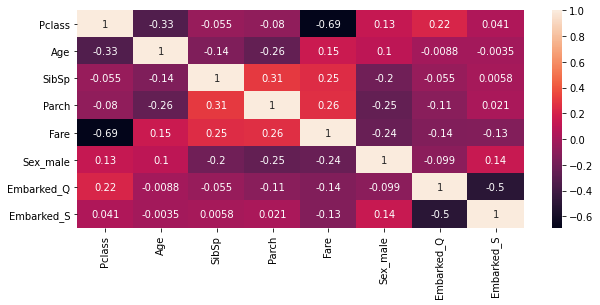

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.heatmap(corr, annot=True)

In [ ]:
redundant_features = []

for i in range(corr.shape[0]):
    for k in range(corr.shape[1]):
        if k > i:
            if abs(corr.iloc[i, k]) >= 0.95:
                print(i, k, corr.iloc[i, k])
                redundant_features.append(X.columns[k])
                continue
redundant_features

[]

In [ ]:
filtered_titanic_data = titanic_data.drop(columns=redundant_features)
filtered_titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,1.0,0.329064,0.333333,0.0,0.043975,1,0,1
1,1,0.0,0.573041,0.333333,0.0,0.432369,0,0,0
2,1,1.0,0.390058,0.000000,0.0,0.048069,0,0,1
3,1,0.0,0.527295,0.333333,0.0,0.322078,0,0,1
4,0,1.0,0.527295,0.000000,0.0,0.048827,1,0,1


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

y = titanic_data.Survived

model = KNeighborsClassifier()

train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True)
model.fit(train_X, train_y)

train_predictions = model.predict(train_X)
print('before: ' + str(accuracy_score(train_y, train_predictions)))

X = filtered_titanic_data[filtered_titanic_data.columns[1:]]
train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True)
model.fit(train_X, train_y)

train_predictions = model.predict(train_X)
print('after: ' + str(accuracy_score(train_y, train_predictions)))

before: 0.8515497553017944
after: 0.8450244698205547


In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

titanic_data2 = titanic_data[['Survived', 'Sex_male', 'Embarked_Q', 'Embarked_S']]
# titanic_data2 = titanic_data

chi2_stats = chi2(titanic_data2, np.array(titanic_data.iloc[:, 0]))[0]
chi2_stats_table = pd.DataFrame({ 'column': titanic_data2.columns[1:], 'chi2_stats': chi2_stats[1:] }) \
    .sort_values(by='chi2_stats', ascending=True)
chi2_stats_table

,column,chi2_stats
1,Embarked_Q,0.340991
2,Embarked_S,4.759596
0,Sex_male,85.323417


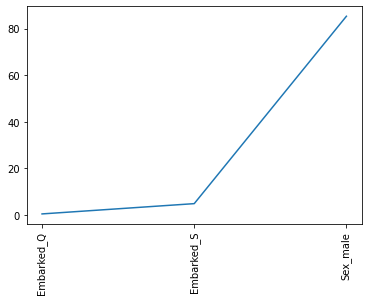

In [ ]:
plt.xticks(rotation='vertical')
plt.plot(chi2_stats_table['column'], chi2_stats_table['chi2_stats'])

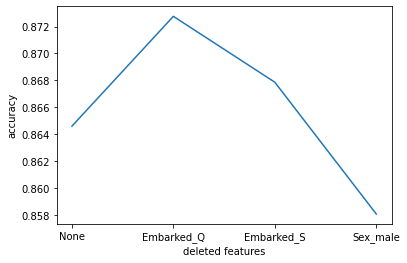

In [ ]:
def plot(model, stats_table, data):
    X = data[data.columns[1:]]
    y = data.Survived

    train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True)
    model.fit(train_X, train_y)

    accuracy = {
        "None": accuracy_score(train_y, model.predict(train_X[X.columns]))
    }
    for feature_name in stats_table['column']:
        model.fit(X, y)
        accuracy[feature_name] = accuracy_score(train_y, model.predict(train_X[X.columns])) 
        X = X.drop(feature_name, axis=1)
        
        if len(X.columns)-1 < 0:
            break

    plt.xlabel("deleted features")
    plt.ylabel("accuracy")
    plt.plot(list(accuracy.keys()), list(accuracy.values()))
    plt.show()

model = KNeighborsClassifier()
plot(model, chi2_stats_table, titanic_data)

In [ ]:
from sklearn.feature_selection import f_classif

titanic_data2 = titanic_data.drop(['Survived', 'Sex_male', 'Embarked_Q', 'Embarked_S'], axis=1)

anova_stats = f_classif(titanic_data2, np.array(titanic_data.iloc[:, 0]))[0]
anova_stats_table = pd.DataFrame({ 'column': titanic_data2.columns[1:], 'anova_stats': anova_stats[1:] }) \
    .sort_values(by='anova_stats', ascending=True)
anova_stats_table

,column,anova_stats
0,Age,7.381101
1,SibSp,7.654651
2,Parch,35.031394
3,Fare,97.587059


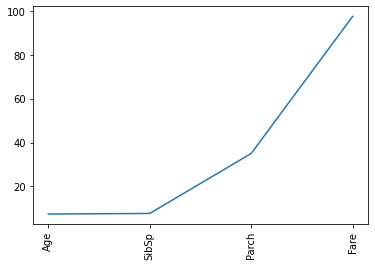

In [ ]:
plt.xticks(rotation='vertical')
plt.plot(anova_stats_table['column'], anova_stats_table['anova_stats'])

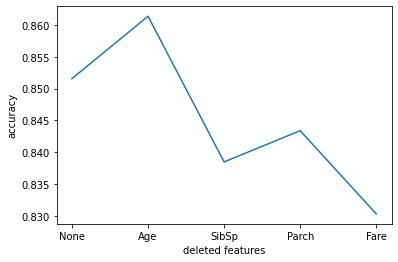

In [ ]:
plot(model, anova_stats_table, titanic_data)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X = titanic_data[titanic_data.columns[1:]]
y = titanic_data.Survived

random_forest_model = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_model, param_grid={'max_depth': range(1, 20)})
grid_search.fit(X, y)
max_depth = grid_search.best_params_['max_depth']
max_depth

10

In [ ]:
random_forest_model = RandomForestClassifier(max_depth=max_depth)
random_forest_model.fit(X, y)

random_forest_stats_table = pd.DataFrame({ 'column': titanic_data.columns[1:], 'random_forest_stats': random_forest_model.feature_importances_ }) \
    .sort_values(by='random_forest_stats', ascending=True)
random_forest_stats_table

,column,random_forest_stats
6,Embarked_Q,0.012597
7,Embarked_S,0.022410
3,Parch,0.041394
2,SibSp,0.047600
0,Pclass,0.078920
1,Age,0.213906
4,Fare,0.255088
5,Sex_male,0.328085


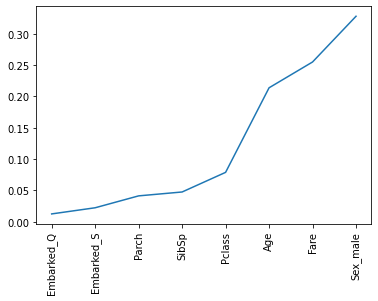

In [ ]:
plt.xticks(rotation='vertical')
plt.plot(random_forest_stats_table['column'], random_forest_stats_table['random_forest_stats'])

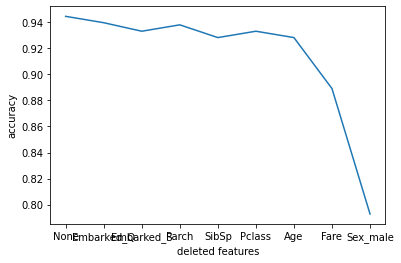

In [ ]:
plot(random_forest_model, random_forest_stats_table, titanic_data)

In [ ]:
X = titanic_data[titanic_data.columns[1:]]
y = titanic_data.Survived

train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True)
random_forest_model.fit(train_X, train_y)

train_predictions = random_forest_model.predict(train_X)
print('before: ' + str(accuracy_score(train_y, train_predictions)))

filtered_titanic_data = titanic_data.drop(columns='Embarked_Q')
X = filtered_titanic_data[filtered_titanic_data.columns[1:]]
train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True)
random_forest_model.fit(train_X, train_y)

train_predictions = random_forest_model.predict(train_X)
print('after: ' + str(accuracy_score(train_y, train_predictions)))

before: 0.9380097879282219
after: 0.9526916802610114


In [ ]:
from sklearn.model_selection import cross_val_score

def forward_selection(data, model, score_delta=0.005, maximum_variables=float("inf")):
    if maximum_variables == float("inf"):
        maximum_variables = len(data.columns)

    X = data[data.columns[1:]]
    y = data.Survived
    variables = {}
    not_used_variables = list(X.columns)
    
    old_score = 0
    for i in range(len(not_used_variables)):
        if len(variables) >= maximum_variables:
            break
        best_score = 0
        best_variable_index = None
        for j in range(len(not_used_variables)):
            new_variables = list(variables)
            new_variables.append(not_used_variables[j])
            score = np.mean(cross_val_score(model, X[new_variables], y))
            if(score > best_score):
                best_score = score
                best_variable_index = j
        if best_score - old_score <= score_delta:
            break
        
        variables[not_used_variables.pop(best_variable_index)] = best_score - old_score
        old_score = best_score
    return variables

forward_selection_stats = forward_selection(titanic_data, model)

forward_selection_stats_table = pd.DataFrame({ 'column': forward_selection_stats.keys(), 'forward_selection_stats': forward_selection_stats.values() }) \
    .sort_values(by='forward_selection_stats', ascending=False)
forward_selection_stats_table

,column,forward_selection_stats
0,Sex_male,0.682418
1,Age,0.109779
2,Pclass,0.028124


In [ ]:
def backward_elimination(data, model, k_columns=5, score_delta=0.05):
    
    X = data[data.columns[1:]]
    y = data.Survived

    column_list = list(X.columns)
    prev_score = np.mean(cross_val_score(model, X, y))
    while len(column_list) > k_columns:
        best_score = 0
        new_columns = None
        for column in column_list:
            tmp_columns = column_list.copy()
            tmp_columns.remove(column)
            score = np.mean(cross_val_score(model, X[tmp_columns], y))

            if score > best_score:
                best_score = score
                new_columns = tmp_columns
        column_to_remove = list(set(column_list) - set(new_columns))
        if prev_score > best_score + score_delta:
            break
        column_list = new_columns
        prev_score = best_score
    return column_list

backward_elimination(titanic_data, model)

['Pclass', 'Age', 'Fare', 'Sex_male', 'Embarked_S']